# Introduction #

Most of the techniques we've seen in this course have been for numerical features. The technique we'll look at in this lesson, *target encoding*, is instead meant for categorical features. It's a method of encoding categories as numbers, like one-hot or label encoding, with the difference that it also uses the *target* to create the encoding. This makes it what we call a **supervised** feature engineering technique.

In [ ]:

import pandas as pd

autos = pd.read_csv("../input/fe-course-data/autos.csv")

# Target Encoding #

A **target encoding** is any kind of encoding that replaces a feature's categories with some number derived from the target.

A simple and effective version is to apply a group aggregation from Lesson 3, like the mean. Using the *Automobiles* dataset, this computes the average price of each vehicle's make:

In [ ]:
autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")

autos[["make", "price", "make_encoded"]].head(10)

This kind of target encoding is sometimes called a **mean encoding**. Applied to a binary target, it's also called **bin counting**. (Other names you might come across include: likelihood encoding, impact encoding, and leave-one-out encoding.)

# Smoothing #

An encoding like this presents a couple of problems, however. First are *unknown categories*. Target encodings create a special risk of overfitting, which means they need to be trained on an independent "encoding" split. When you join the encoding to future splits, Pandas will fill in missing values for any categories not present in the encoding split. These missing values you would have to impute somehow.

Second are *rare categories*. When a category only occurs a few times in the dataset, any statistics calculated on its group are unlikely to be very accurate. In the *Automobiles* dataset, the `mercurcy` make only occurs once. The "mean" price we calculated is just the price of that one vehicle, which might not be very representative of any Mercuries we might see in the future. Target encoding rare categories can make overfitting more likely.

A solution to these problems is to add **smoothing**. The idea is to blend the *in-category* average with the *overall* average. Rare categories get less weight on their category average, while missing categories just get the overall average.

In pseudocode:
```
encoding = weight * in_category + (1 - weight) * overall
```
where `weight` is a value between 0 and 1 calculated from the category frequency.

An easy way to determine the value for `weight` is to compute an **m-estimate**:
```
weight = n / (n + m)
```
where `n` is the total number of times that category occurs in the data. The parameter `m` determines the "smoothing factor". Larger values of `m` put more weight on the overall estimate.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/1uVtQEz.png" width=500, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

In the *Automobiles* dataset there are three cars with the make `chevrolet`. If you chose `m=2.0`, then the `chevrolet` category would be encoded with 60% of the average Chevrolet price plus 40% of the overall average price.
```
chevrolet = 0.6 * 6000.00 + 0.4 * 13285.03
```

When choosing a value for `m`, consider how noisy you expect the categories to be. Does the price of a vehicle vary a great deal within each make? Would you need a lot of data to get good estimates? If so, it could be better to choose a larger value for `m`; if the average price for each make were relatively stable, a smaller value could be okay.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Use Cases for Target Encoding</strong><br>
Target encoding is great for:
<ul>
<li><strong>High-cardinality features</strong>: A feature with a large number of categories can be troublesome to encode: a one-hot encoding would generate too many features and alternatives, like a label encoding, might not be appropriate for that feature. A target encoding derives numbers for the categories using the feature's most important property: its relationship with the target.
<li><strong>Domain-motivated features</strong>: From prior experience, you might suspect that a categorical feature should be important even if it scored poorly with a feature metric. A target encoding can help reveal a feature's true informativeness.
</ul>
</blockquote>

# Example - MovieLens1M #

The [*MovieLens1M*](https://www.kaggle.com/grouplens/movielens-20m-dataset) dataset contains one-million movie ratings by users of the MovieLens website, with features describing each user and movie. This hidden cell sets everything up:

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


df = pd.read_csv("data/a18/movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

Number of Unique Zipcodes: 3439


With over 3000 categories, the `Zipcode` feature makes a good candidate for target encoding, and the size of this dataset (over one-million rows) means we can spare some data to create the encoding.

We'll start by creating a 25% split to train the target encoder.

In [2]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

The `category_encoders` package in `scikit-learn-contrib` implements an m-estimate encoder, which we'll use to encode our `Zipcode` feature.

In [3]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)

Let's compare the encoded values to the target to see how informative our encoding might be.

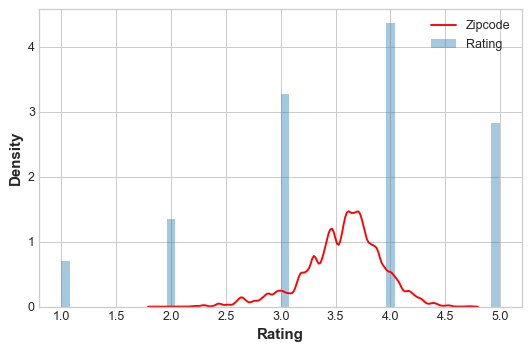

In [5]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

# plt.savefig("../img/a18f-01.png")

The distribution of the encoded `Zipcode` feature roughly follows the distribution of the actual ratings, meaning that movie-watchers differed enough in their ratings from zipcode to zipcode that our target encoding was able to capture useful information.

# Your Turn #

[**Apply target encoding**](https://www.kaggle.com/kernels/fork/14393917) to features in *Ames* and investigate a surprising way that target encoding can lead to overfitting.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/221677) to chat with other Learners.*